In [60]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv("UNRATE.csv", header = None)
df.columns = ["Date", "UNRATE"]
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df.set_index("Date")
df.head(20)

,Date,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
5,1948-06-01,3.6
6,1948-07-01,3.6
7,1948-08-01,3.9
8,1948-09-01,3.8
9,1948-10-01,3.7


In [72]:
df.head()

,Date,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [74]:
train_len = 612
test_len = 255
train= df[:train_len]
test = df[train_len:]
train.shape, test.shape

((612, 2), (255, 2))

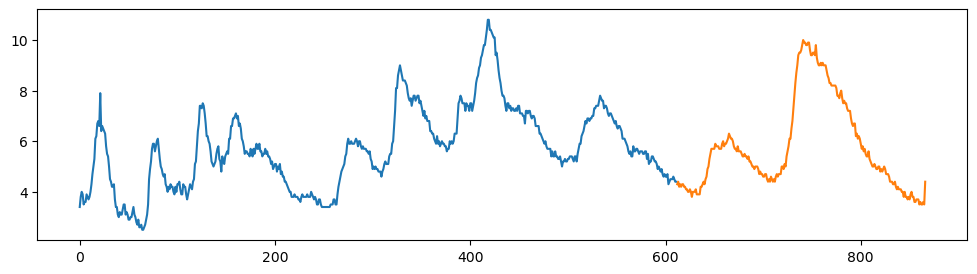

In [75]:
plt.figure(figsize=(12, 3))
plt.plot(train["UNRATE"])
plt.plot(test["UNRATE"])
plt.show()

In [76]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['UNRATE'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.143963
Critical Values @ 0.05: -2.86
p-value: 0.023466


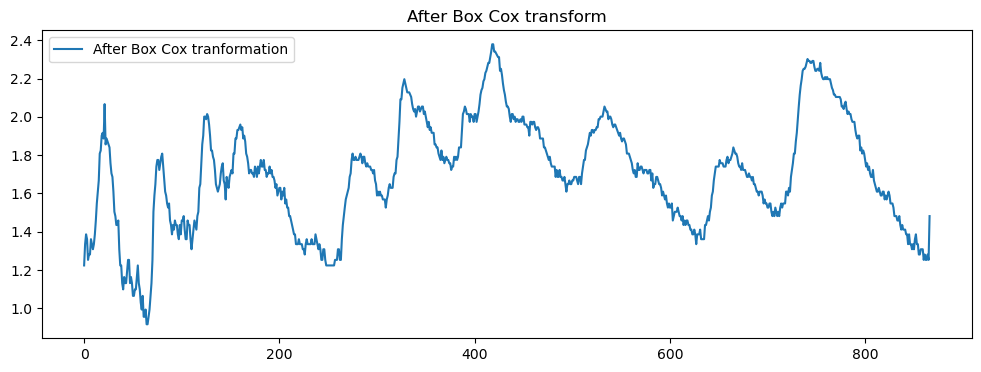

In [77]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(df['UNRATE'], lmbda=0), index = df.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

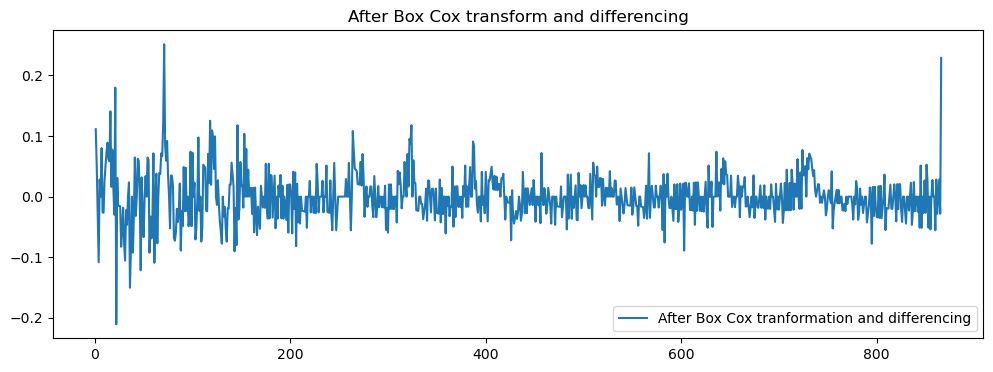

In [78]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), df.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [79]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data_boxcox_diff.dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.918955
Critical Values @ 0.05: -2.86
p-value: 0.000000


In [80]:
AR_DF = data_boxcox_diff.dropna()
AR_DF_train = AR_DF[:train_len-1]
AR_DF_train = AR_DF[train_len-1:]

In [90]:
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA

In [81]:
model = ARIMA(AR_DF_train, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const     0.001242
ar.L1    -0.124091
ar.L2     0.200872
ar.L3     0.112134
ar.L4    -0.011946
ar.L5     0.280102
ar.L6     0.161980
ar.L7     0.108200
ar.L8     0.007862
ar.L9     0.036920
ar.L10    0.041361
ar.L11   -0.028819
ar.L12   -0.161011
sigma2    0.000767
dtype: float64


In [82]:
y_hat_ar = AR_DF.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(AR_DF.index.min(), AR_DF.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

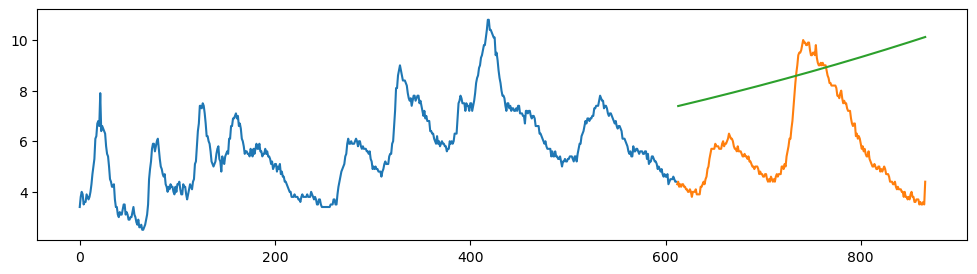

In [83]:
plt.figure(figsize=(12, 3))
plt.plot(train["UNRATE"])
plt.plot(test["UNRATE"])
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.show()

In [84]:
pred = y_hat_ar['ar_forecast'][test.index.min():]
pred.shape

(254,)

In [85]:
test[:-1].shape

(254, 2)

In [86]:
from sklearn.metrics import mean_squared_error

In [87]:
def printMet(actual, pred):
    print("MSE", np.sqrt(mean_squared_error(actual, pred)))
    print("MAPE", np.mean(abs(actual - pred)/actual*100))

In [88]:
test["UNRATE"][:-1]

612    4.3
613    4.4
614    4.2
615    4.3
616    4.2
      ... 
861    3.6
862    3.5
863    3.5
864    3.6
865    3.5
Name: UNRATE, Length: 254, dtype: float64

In [89]:
printMet(test["UNRATE"][:-1], pred)

MSE 3.4981990622738053
MAPE 64.98617318947024
